In [1]:
import os
import sys
import yaml
import torch
import logging
import argparse
import numpy as np
import seaborn as sn
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from pytorch_lightning import seed_everything
from torchmetrics.functional import mean_squared_error as mse
from torchmetrics.functional import peak_signal_noise_ratio as psnr
from torchmetrics.functional import structural_similarity_index_measure as ssim
from torchmetrics import ConfusionMatrix, F1Score, Accuracy, Precision, Recall, ConfusionMatrix
sys.path.append('../')
from utils import parameter_manager, model_loader
from core import datamodule, lrn, modulator, propagator, classifiers, cooperative

plt.style.use('seaborn-v0_8')


f1 = F1Score(task = 'multiclass', num_classes = 10, top_k = 1).cpu()
acc = Accuracy(task = 'multiclass', num_classes = 10, top_k = 1).cpu()
prec = Precision(task = 'multiclass', num_classes = 10, top_k = 1).cpu()
rec = Recall(task = 'multiclass', num_classes = 10, top_k = 1).cpu()
cfm = ConfusionMatrix(task = 'multiclass', num_classes=10, top_k = 1).cpu()
#logging.basicConfig(level=logging.DEBUG)

In [2]:
# Load parameters
params = yaml.load(open('../config.yaml'), Loader = yaml.FullLoader)
params['batch_size'] = 1
params['distance'] = torch.tensor(0.60264)


pm = parameter_manager.Parameter_Manager(params = params)
#pm.path_data = '/cgi/data/erdc_xai/resolution_constrained_deep_optics/data/'
#pm.collect_params()

# Load in the test dataset
pm.data_split = "mnist_1000perClass"
datamod = datamodule.select_data(pm.params_datamodule)
datamod.setup()
dataloader_train_1000perClass = datamod.train_dataloader()
dataloader_test = datamod.test_dataloader()

datasets = ['mnist_single0', 'mnist_single1', 'mnist_10_1', 'mnist_10_8', 'mnist_100_1', 'mnist_100_8', 'mnist_1perClass', 'mnist_10perClass', 'mnist_100perClass', 'mnist_1000perClass']
 
data_loaders = {}
for data in datasets:
    pm.data_split = data
    datamod = datamodule.select_data(pm.params_datamodule)
    datamod.setup()
    loader = datamod.train_dataloader()
    data_loaders[f'{data}'] = loader
    

In [3]:
pwd

'/home/mblgh6/Documents/rcdo/evaluations'

---
## Utils for eval
---

In [3]:
def eval_model(model, dataloader):
    print(len(dataloader))
    classifier_outputs = []
    lrn_measures = []
    for i,batch in enumerate(tqdm(dataloader)):
    #for i,batch in enumerate(dataloader):
    #    if i %10 == 0:
    #        print(i)
        sample,target = batch
        sample = sample.cuda()
        target = target.cuda()
        batch = (sample,target)
        
        lrn_output, prediction = model.shared_step(batch, i)
        lrn_measures.append(run_lrn_measures(lrn_output))
        
        classifier_outputs.append((torch.argmax(prediction.detach().cpu()), target.detach().cpu().squeeze()))
        #from IPython import embed; embed()
    classifier_outputs = torch.from_numpy(np.asarray(classifier_outputs))
    classifier_measures = run_classifier_measures(classifier_outputs)
    
    return lrn_measures, classifier_measures

def run_lrn_measures(lrn_outputs):
    wavefronts = lrn_outputs[0]
    amplitudes = lrn_outputs[1] 
    normalized_amplitudes = lrn_outputs[2]
    images = lrn_outputs[3]
    normalized_images = lrn_outputs[4]
    lrn_target = lrn_outputs[5]

    mse_vals = mse(normalized_images.detach(), lrn_target.detach())
    psnr_vals = psnr(normalized_images.detach(), lrn_target.detach())
    ssim_vals = ssim(normalized_images.detach(), lrn_target.detach()).detach()
    return {'mse' : mse_vals.cpu(), 'psnr' : psnr_vals.cpu(), 'ssim' : ssim_vals.cpu()}

def run_classifier_measures(classifier_outputs):
    predictions, targets = classifier_outputs[:,0], classifier_outputs[:,1]
    precision = prec(preds= predictions, target=targets)
    recall = rec(preds = predictions, target=targets)
    f1_score = f1(preds = predictions, target=targets)
    accuracy = acc(preds = predictions, target=targets)
    confusion_matrix = cfm(preds=predictions, target = targets)  
    return {'prec':precision, 'rec':recall, 'f1':f1_score, 'acc':accuracy, 'cfm':confusion_matrix}

In [4]:
#Load the model in 
#model = cooperative.CooperativeOptimization.load_from_checkpoint('../my_models/cooperative/test_cooperative_lrnLearned/epoch=1-step=2500.ckpt')
model = cooperative.CooperativeOptimization.load_from_checkpoint('../my_models/cooperative/predict_test/epoch=4-step=6250-v2.ckpt')
model.eval()
model = model.cuda()

In [5]:
lrn_measures, classifier_measures = eval_model(model, data_loaders['mnist_1000perClass'])

10000


  0%|          | 0/10000 [00:00<?, ?it/s]

/home/mblgh6/Documents/rcdo/evaluations/../core/lrn.py:140: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:250.)
  target = sample.double()


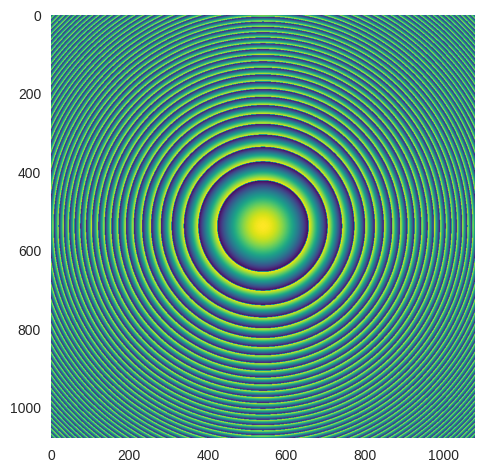

In [6]:
plt.imshow(model.lrn.layers[1].phase.squeeze().cpu().detach() % (2*np.pi), cmap='viridis')
plt.grid(False)

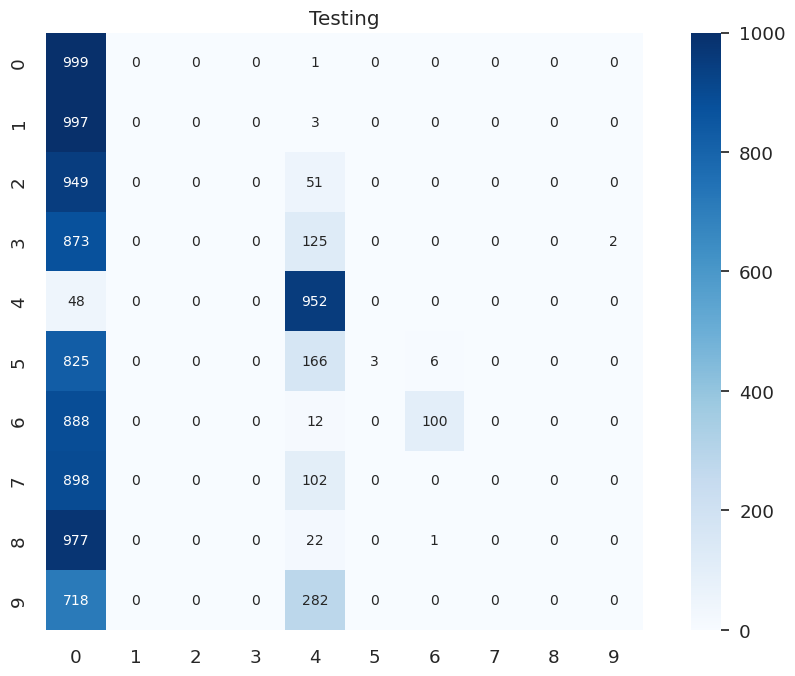

In [7]:
df_cm = pd.DataFrame(classifier_measures['cfm'], index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
plt.figure(figsize = (10,7))
sn.set(font_scale=1.2)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10},cmap='Blues', fmt='g', vmax=1000, vmin=0, linecolor='black', square=True)
plt.title("Testing")
plt.tight_layout()
plt.savefig("testing.pdf")

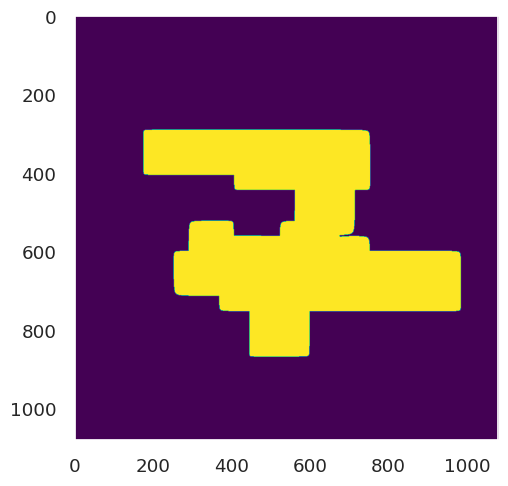

In [11]:
# Get a good image for comparisons
number = 500
for i,batch1 in enumerate(dataloader_test):
    if i == number:
        break
fig,ax = plt.subplots(1,1)
ax.imshow(batch1[0].abs().squeeze(), cmap='viridis')
ax.grid(False)


In [9]:
sample,target = batch1
sample = sample.cuda()
target = target.cuda()
batch1 = (sample,target)
lrn_output, prediction = model.forward(batch1, 0)

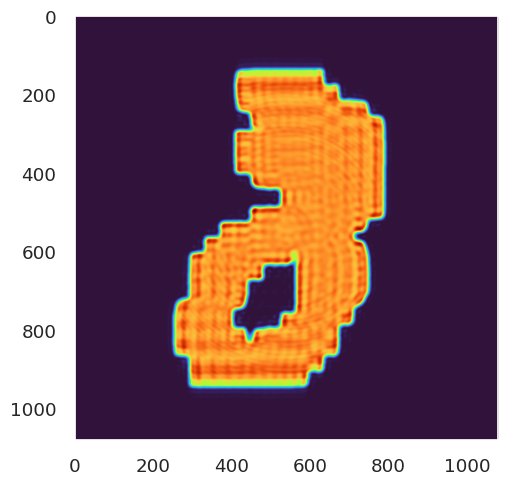

In [10]:
plt.imshow(lrn_output[3].cpu().squeeze().detach(), cmap='turbo')
plt.grid(False)

In [12]:
torch.argmax(prediction)

tensor(5, device='cuda:0')

In [13]:
classifier_measures

{'prec': tensor(0.9557),
 'rec': tensor(0.9557),
 'f1': tensor(0.9557),
 'acc': tensor(0.9557),
 'cfm': tensor([[950,   0,   0,   1,   0,  16,  14,   0,  11,   8],
         [  0, 938,   3,   3,   3,   5,   2,   1,  39,   6],
         [  0,   3, 935,  26,   3,   2,   7,   4,  20,   0],
         [  0,   0,   0, 981,   0,  12,   1,   3,   1,   2],
         [  0,   1,   0,   0, 938,   1,   8,   1,   7,  44],
         [  0,   0,   0,   9,   0, 985,   0,   0,   5,   1],
         [  0,   1,   0,   0,   1,  18, 980,   0,   0,   0],
         [  0,   1,   2,  11,   7,   3,   0, 942,   3,  31],
         [  0,   1,   1,  14,   1,  35,   2,   0, 935,  11],
         [  0,   0,   0,  12,   2,   8,   1,   2,   2, 973]])}